# Udacity Data Scientist Nanodegree
## Project 1

**Problem:** Governments, NGOs, and other firms / institutions often need to predict poverty rates in order to properly allocate funding, design laws and programs, and/or evaluate the country's risk and health.

**Business Goal:** Predict a country's poverty rate based on its literacy rate, unemployment rate, and birth rate

**Steakholders:** Government, NGOs, educational institutions, health institutions, etc.

In [1]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

### Data Understanding Part I:

**Data Source:** [The World Bank](https://databank.worldbank.org/source/health-nutrition-and-population-statistics)

In [2]:
health_data = pd.read_csv('./health_nutrition_population_data.csv')
health_data.head()

,Series Name,Series Code,Country Name,Country Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],...,2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
0,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,Afghanistan,AFG,50.34,50.443,50.57,50.703,50.831,50.872,...,39.105,38.803,37.936,37.342,36.927,36.466,36.051,35.842,35.143,..
1,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,Africa Eastern and Southern,AFE,47.4378249166233,47.5278988875246,47.593643414273,47.6311882616836,47.6398403331442,47.6619065454766,...,36.0346477690784,35.620577474946,35.198243349763,34.9034964248211,34.6191996859734,34.3449558233055,33.9151126919843,33.5395026451101,33.128841081925,..
2,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,Africa Western and Central,AFW,47.3233713504097,47.4182988424827,47.5260474057589,47.52741513875,47.5079217373617,47.4647220992777,...,39.3506452446674,38.8726245472865,38.4062431121107,37.8955413261248,37.4560511185931,37.0332780332928,36.6178473034092,36.236189183317,35.7706019676744,..
3,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,Albania,ALB,41.068,40.332,39.216,38.149,36.825,35.362,...,12.15,11.718,11.289,10.87,10.517,10.343,10.285,10.24,10.116,..
4,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,Algeria,DZA,48.722,48.634,48.68,48.593,48.392,48.021,...,25.404,25.405,25.166,24.755,24.074,23.298,22.431,21.524,20.572,..


### Data Preparation:

1. I dropped unnecessary columns such as Series Code and Country Code, as it was duplicate info already in the data in other columns.
2. I removed blank rows and rows that had 'Data from database' and 'Last updated' info.
3. I melted from wide to long format, as this is the format we'll want for the linear regression.
4. I replaced '..' with NaNs.
5. I renamed columns and cleaned up the year field to be in the proper format.
6. I looked at missing data. Key takeaways: 1) % overweight column is not filled in super well from 1960-2022, so we should remove it for our analysis. 2) Columns such as literacy and unemployment rate start off in 1960 as not being filled in, but get more data in 2022 / 2023. Because of that, I decided to forward and back fill missing data (rather than remove it, as that would have gotten rid of a lot of the data).
7. I decided to just take the most recent year of data with the most complete data, which was 2022.
8. I removed the % overweight column, and I also decided to drop any remaining NULL data after forward/back filling.

In [4]:
# Drop unnecessary columns (Series Code and Country Code give us duplicate info already in data)

health_data.drop(['Series Code', 'Country Code'], axis = 1, inplace = True)
health_data.head()

,Series Name,Country Name,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],1966 [YR1966],1967 [YR1967],...,2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
0,"Birth rate, crude (per 1,000 people)",Afghanistan,50.34,50.443,50.57,50.703,50.831,50.872,50.986,51.081,...,39.105,38.803,37.936,37.342,36.927,36.466,36.051,35.842,35.143,..
1,"Birth rate, crude (per 1,000 people)",Africa Eastern and Southern,47.4378249166233,47.5278988875246,47.593643414273,47.6311882616836,47.6398403331442,47.6619065454766,47.6929052695047,47.6874654856282,...,36.0346477690784,35.620577474946,35.198243349763,34.9034964248211,34.6191996859734,34.3449558233055,33.9151126919843,33.5395026451101,33.128841081925,..
2,"Birth rate, crude (per 1,000 people)",Africa Western and Central,47.3233713504097,47.4182988424827,47.5260474057589,47.52741513875,47.5079217373617,47.4647220992777,47.4398848353447,47.4221514734314,...,39.3506452446674,38.8726245472865,38.4062431121107,37.8955413261248,37.4560511185931,37.0332780332928,36.6178473034092,36.236189183317,35.7706019676744,..
3,"Birth rate, crude (per 1,000 people)",Albania,41.068,40.332,39.216,38.149,36.825,35.362,34.356,33.898,...,12.15,11.718,11.289,10.87,10.517,10.343,10.285,10.24,10.116,..
4,"Birth rate, crude (per 1,000 people)",Algeria,48.722,48.634,48.68,48.593,48.392,48.021,47.628,47.374,...,25.404,25.405,25.166,24.755,24.074,23.298,22.431,21.524,20.572,..


In [5]:
health_data['Series Name'].unique()

array(['Birth rate, crude (per 1,000 people)',
       'Unemployment, total (% of total labor force)',
       'Literacy rate, adult total (% of people ages 15 and above)',
       'Poverty headcount ratio at national poverty line (% of population)',
       'Prevalence of overweight (% of adults)', nan,
       'Data from database: Health Nutrition and Population Statistics',
       'Last Updated: 12/16/2024'], dtype=object)

In [6]:
# Remove unnecessary rows with NULLs, data source info, and last updated date

health_data = health_data[~health_data['Series Name'].isin(['Data from database: Health Nutrition and Population Statistics',
                                                          'Last Updated: 12/16/2024']) &
                          health_data['Series Name'].notna()]

health_data['Series Name'].unique()

array(['Birth rate, crude (per 1,000 people)',
       'Unemployment, total (% of total labor force)',
       'Literacy rate, adult total (% of people ages 15 and above)',
       'Poverty headcount ratio at national poverty line (% of population)',
       'Prevalence of overweight (% of adults)'], dtype=object)

In [6]:
# Melt data into proper format, replace .. with NaNs

df_long = pd.melt(health_data, id_vars=['Country Name', 'Series Name'],
             var_name='Year', value_name='Value')

df_long['Value'] = df_long['Value'].replace('..', np.nan)
df_long['Value'] = pd.to_numeric(df_long['Value'], errors = 'coerce')

df = df_long.pivot_table(index = ['Country Name', 'Year'], columns = 'Series Name', values = 'Value').reset_index()

df.head()

Series Name,Country Name,Year,"Birth rate, crude (per 1,000 people)","Literacy rate, adult total (% of people ages 15 and above)",Poverty headcount ratio at national poverty line (% of population),Prevalence of overweight (% of adults),"Unemployment, total (% of total labor force)"
0,Afghanistan,1960 [YR1960],50.340,NaN,NaN,NaN,NaN
1,Afghanistan,1961 [YR1961],50.443,NaN,NaN,NaN,NaN
2,Afghanistan,1962 [YR1962],50.570,NaN,NaN,NaN,NaN
3,Afghanistan,1963 [YR1963],50.703,NaN,NaN,NaN,NaN
4,Afghanistan,1964 [YR1964],50.831,NaN,NaN,NaN,NaN


In [7]:
# Rename columns

df.columns = ['Country', 'Year', 'Birth rate', 'Literacy rate', 'Poverty rate', '% overweight', 'Unemployment rate']

df.head()

,Country,Year,Birth rate,Literacy rate,Poverty rate,% overweight,Unemployment rate
0,Afghanistan,1960 [YR1960],50.340,NaN,NaN,NaN,NaN
1,Afghanistan,1961 [YR1961],50.443,NaN,NaN,NaN,NaN
2,Afghanistan,1962 [YR1962],50.570,NaN,NaN,NaN,NaN
3,Afghanistan,1963 [YR1963],50.703,NaN,NaN,NaN,NaN
4,Afghanistan,1964 [YR1964],50.831,NaN,NaN,NaN,NaN


In [8]:
# Clean year values

df['Year'] = df['Year'].str.split().str[0]
df['Year'] = df['Year'].astype(int)
df.head()

,Country,Year,Birth rate,Literacy rate,Poverty rate,% overweight,Unemployment rate
0,Afghanistan,1960,50.340,NaN,NaN,NaN,NaN
1,Afghanistan,1961,50.443,NaN,NaN,NaN,NaN
2,Afghanistan,1962,50.570,NaN,NaN,NaN,NaN
3,Afghanistan,1963,50.703,NaN,NaN,NaN,NaN
4,Afghanistan,1964,50.831,NaN,NaN,NaN,NaN


In [9]:
# Check missing data

missing_data = df.groupby('Year').apply(lambda x: x.isna().sum())
missing_data

,Country,Year,Birth rate,Literacy rate,Poverty rate,% overweight,Unemployment rate
Year,,,,,,,
1960,0,0,0,250,250,250,250
1961,0,0,0,249,249,249,249
1962,0,0,0,250,250,250,250
1963,0,0,0,249,249,249,249
1964,0,0,0,249,249,249,249
...,...,...,...,...,...,...,...
2019,0,0,0,181,196,259,28
2020,0,0,0,186,204,258,27
2021,0,0,0,171,191,257,26


In [10]:
# Forward and back fill missing data

df = df.sort_values(['Country', 'Year'])
df_filled = df.groupby('Country').apply(lambda group: group.ffill().bfill()).reset_index(drop = True)

df_filled.head()

,Country,Year,Birth rate,Literacy rate,Poverty rate,% overweight,Unemployment rate
0,Afghanistan,1960,50.340,18.0,33.7,6.1,7.946
1,Afghanistan,1961,50.443,18.0,33.7,6.1,7.946
2,Afghanistan,1962,50.570,18.0,33.7,6.1,7.946
3,Afghanistan,1963,50.703,18.0,33.7,6.1,7.946
4,Afghanistan,1964,50.831,18.0,33.7,6.1,7.946


In [11]:
df_filled.isna().sum()

Country                 0
Year                    0
Birth rate              0
Literacy rate        3253
Poverty rate         6262
% overweight         1517
Unemployment rate    1556
dtype: int64

In [30]:
# Take the most recent year of data available

subset1 = df_filled[df_filled['Year'] == 2022]

In [31]:
# Drop % overweight column, as it's largely NULLs

subset1.drop('% overweight', axis = 1, inplace = True)
subset1 = subset1.dropna()

C:\Users\EPARSHB\AppData\Local\Temp\1\ipykernel_21120\1205840324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset1.drop('% overweight', axis = 1, inplace = True)


### Data Understanding Part II:

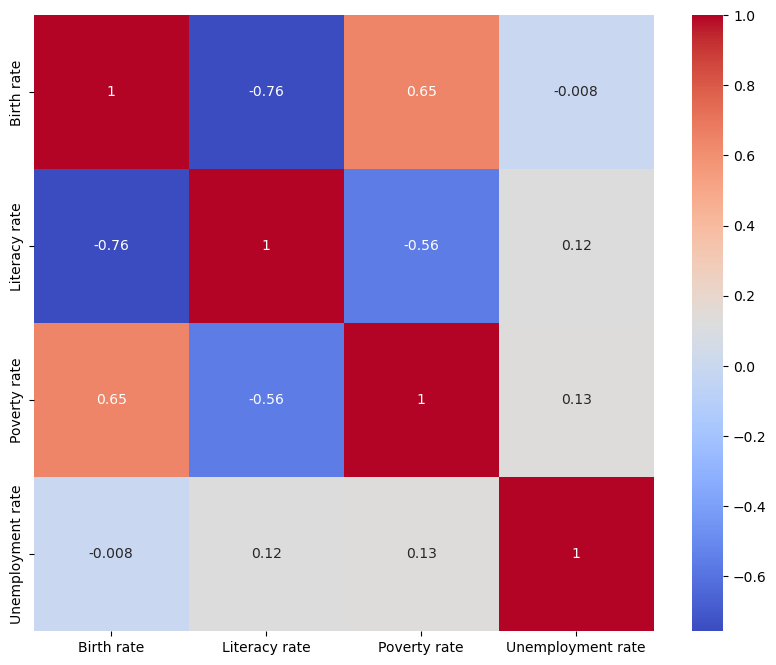

In [32]:
# Correlation matrix

plt.figure(figsize=(10,8))
sns.heatmap(subset1[['Birth rate', 'Literacy rate', 'Poverty rate', 'Unemployment rate']].corr(), annot = True, cmap = 'coolwarm')
plt.title = ("Health Data Correlation Matrix")
plt.show()

From the correlation matrix, I can see that birth and literacy rates have the strongest relationships with poverty rate, with birth rate having a positive relationship and literacy rate having a negative relationship with poverty rate.

In [12]:
df_long = pd.melt(health_data, id_vars=['Country Name', 'Series Name'],
             var_name='Year', value_name='Value')
df_long.columns = ['Country', 'Variable', 'Year', 'Value']
var_map = {'Birth rate, crude (per 1,000 people)' : 'Birth rate',
           'Unemployment, total (% of total labor force)' : 'Unemployment rate',
           'Literacy rate, adult total (% of people ages 15 and above)' : 'Literacy rate',
           'Poverty headcount ratio at national poverty line (% of population)' : 'Poverty rate',
           'Prevalence of overweight (% of adults)' : '% overweight'}
df_long['Variable'] = df_long['Variable'].replace(var_map)
df_long['Year'] = df_long['Year'].str.split().str[0]
df_long['Year'] = df_long['Year'].astype(int)
df_long['Value'] = df_long['Value'].replace('..', np.nan)
df_long['Value'] = pd.to_numeric(df_long['Value'], errors = 'coerce')
df_long = df_long[df_long['Variable'] != '% overweight']

df_long.head()

,Country,Variable,Year,Value
0,Afghanistan,Birth rate,1960,50.340000
1,Africa Eastern and Southern,Birth rate,1960,47.437825
2,Africa Western and Central,Birth rate,1960,47.323371
3,Albania,Birth rate,1960,41.068000
4,Algeria,Birth rate,1960,48.722000


In [14]:
subset = df_long[df_long['Year'] == 2022]

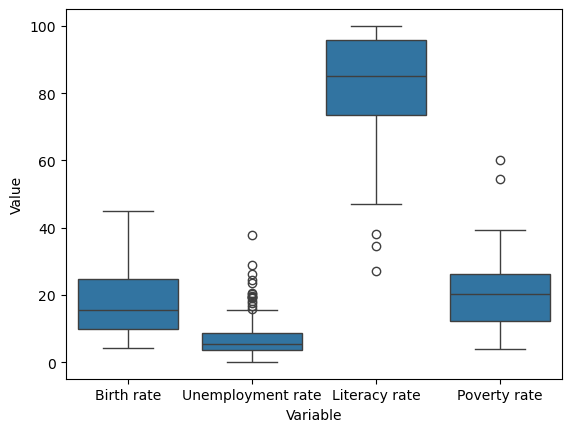

In [15]:
sns.boxplot(x=subset['Variable'], y = subset['Value']);

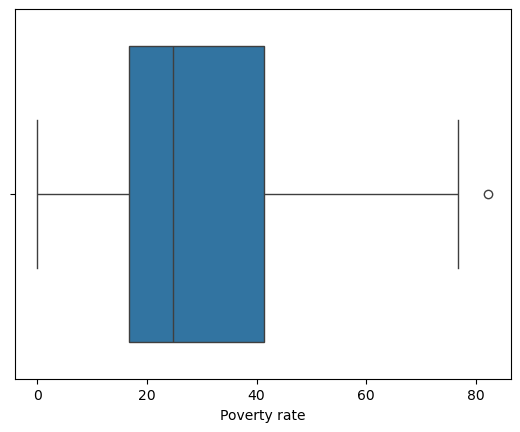

In [33]:
sns.boxplot(x=subset1['Poverty rate']);

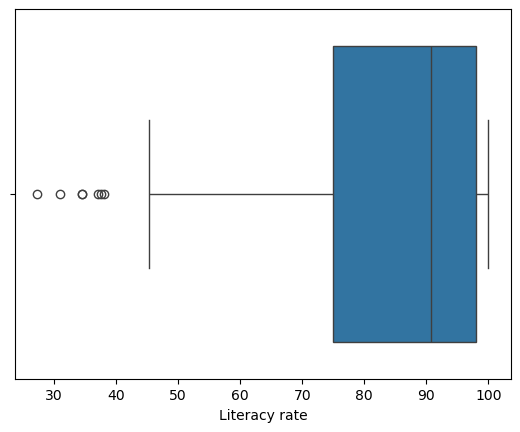

In [34]:
sns.boxplot(x = subset1['Literacy rate']);

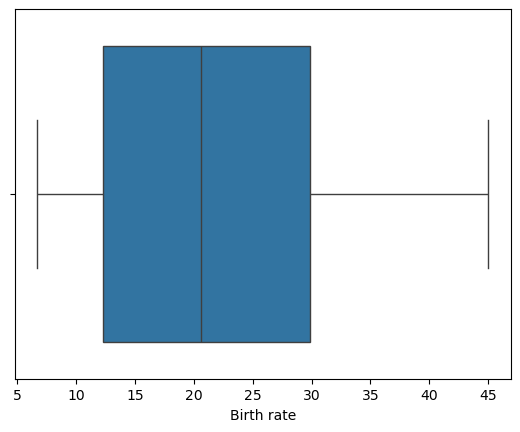

In [35]:
sns.boxplot(x = subset1['Birth rate']);

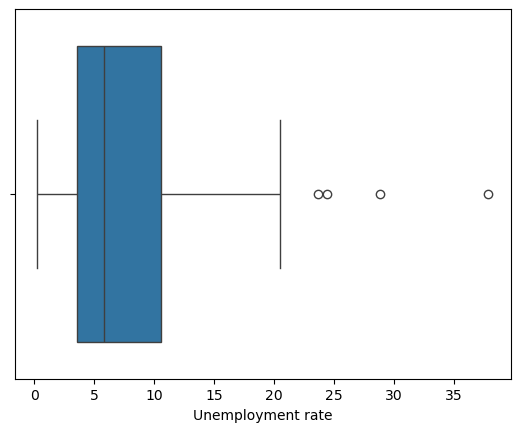

In [36]:
sns.boxplot(x = subset1['Unemployment rate']);

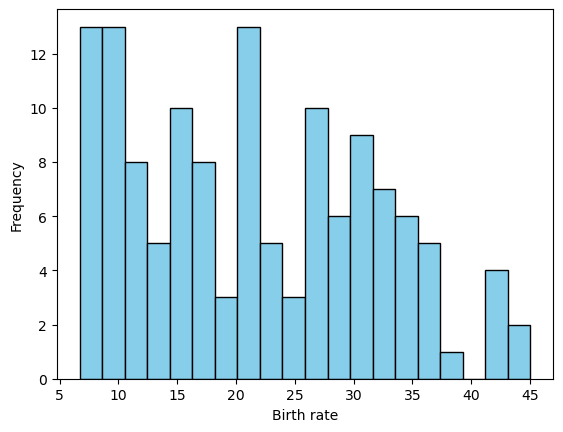

In [37]:
plt.hist(subset1['Birth rate'], bins = 20, color = 'skyblue', edgecolor = 'black')
plt.xlabel('Birth rate')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

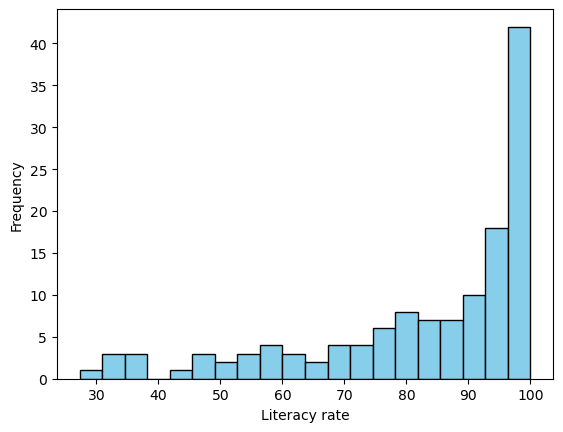

In [38]:
plt.hist(subset1['Literacy rate'], bins = 20, color = 'skyblue', edgecolor = 'black')
plt.xlabel('Literacy rate')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

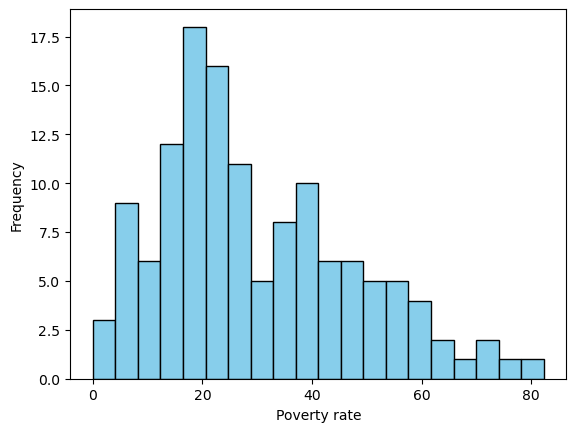

In [39]:
plt.hist(subset1['Poverty rate'], bins = 20, color = 'skyblue', edgecolor = 'black')
plt.xlabel('Poverty rate')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

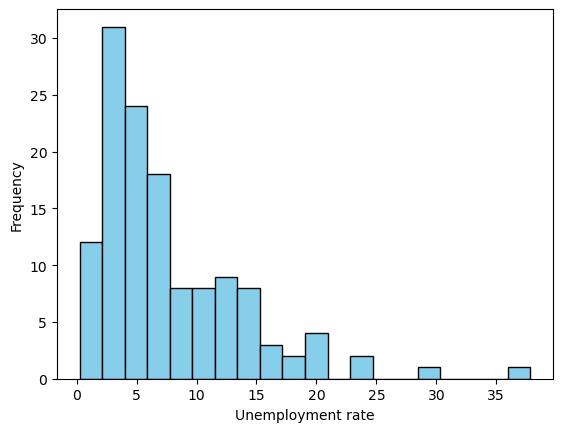

In [40]:
plt.hist(subset1['Unemployment rate'], bins = 20, color = 'skyblue', edgecolor = 'black')
plt.xlabel('Unemployment rate')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

The boxplots and histograms show us the distribution of the different metrics. Birth rate stands out to me as having a non-normal distribution here.

### Modeling:

**Select the algorithm:** I chose linear regression, as we can use this model / algorithm to predict poverty rates, which is a continuous variable.

In [101]:
X = subset1.drop(['Country', 'Poverty rate'], axis = 1)
y = subset1['Poverty rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 14)

In [102]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [103]:
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)

print('Test set RMSE:', rmse)

Test set RMSE: 10.060614250513419


In [104]:
r2 = model.score(X_test, y_test)
print('Test set R^2:', r2)

Test set R^2: 0.659944171943246


In [107]:
lr = pd.DataFrame(model.coef_, X.columns, columns=['Coefficients'])
print(lr)

                   Coefficients
Year                   0.000000
Birth rate             0.784742
Literacy rate         -0.196054
Unemployment rate      0.450782


In [109]:
model.intercept_

26.370145767981786

### Evaluation:

An $R^2$ of 0.66 suggests that the model explains a somewhat significant portion of the variability in poverty rate. An MSE of 10.06 indicates lower average prediction errors. The coefficients show that birth rate and unemployment rate have a positive relationship with poverty rate, while literacy rate has a negative relationship with poverty rate. Additionally, the coefficients show that birth rate has the highest effect on poverty rate out of all the features in our model. Overall, these metrics suggest that the linear regression model is performing well, but there could still be room for improvement either by adding / using different features, using a different model, and/or improving the data quality (especially because I forward/backfilled a lot of the data).